# The Dataset

Our dataset is composed by recording made by som tag around the world. Those tags record at a given point of time some information about a storm such as the strenght, the location, the wind speed, ... All the records has been made from 1980 onwards.

# Necessary features and expectations :

- Create a Machine Learning solution to predict the strenght of tropiical storms, based on geographical inputs.
- The severity appear in the traget column "TD9636_STAGE" of our Dataset.
- We need to follow along a whole pipeling solution to deploy an app, which will take geographical coodinates as input and will return the strenght of the storm.

## First ideas on the exploration

- Look at how a strom evolve during time.
- Look how the storms are affected by the location, in terme of geographic basin, to see if it affect the behaviour of the storm.
- Look how the storm affect the wind speed during its life.

In [84]:
# We need first to import all the packages we will use during the exploration of the dataset

#Data handling tools :
import numpy as np #Used for arithmetic operations
import pandas as pd #Used to handle the csv dataset and use it as a dataframe

#Plotting tools :
import seaborn as sns #Used for plotting
import matplotlib.pyplot as plt #Used also for plotting
import plotly.express as px #Used also for plotting
from mpl_toolkits.mplot3d import Axes3D #Used for 3d plotting and heatmap
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot #More tools for plotting offline

#Maps features tools :
import cartopy.crs as ccrs #Used for the static maps features
import cartopy.feature as cfeature #Used for the static maps features
import folium #To create an interactive map
from folium.plugins import MarkerCluster #To help us generating data on the interactive map
from geopy.distance import geodesic # Help us calculate come distances on a map
import matplotlib.colors as mcolors

#Offline tools :
import plotly.graph_objects as go #Used to acces more tools during plotting like putting notebook offline
import cufflinks as cf #Only used to put the notebook offline

#Other tools :
import missingno as msno #This help us to handle some missing values
import ipywidgets as widgets #Needed to create a slider in an intercative map
from IPython.display import display #Helping to haandle the render of some parts of the notebook
import branca.colormap as cm #This help to calculate distance from two points identified by the coordinates of those points

In [85]:
#Needed function to make distribution
def distribution(var,df): #This function avoid to copy several times the same code in plotting
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=var)
    plt.title(f"Distribution de la variable {var}")
    plt.xlabel("Modalités")
    plt.ylabel("Nombre d'individus par modalité")
    plt.show()

# Loading of the dataset and first look at our data
By just opening the csv data set into Excel, we can already observe some facts :
- The ISO_TIME column don't have any missing values, this one has been construct like a timeline.
- Our target, the "TD9636_STAGE" column has a lot of missing values. Indeed the data in it are reading made by a beacon when a storm appear. As, hopefully, the storms aren't continuous, we obviously have missing values when we don't have storms.
- The values in the "TD9636_STAGE" column (target) are class, the severity of the storm in a range from 0 to 7. Here the 0 is the lowest intensity, 6 is the highest and 7 is considered as a doubtful record or unidentified record. Maybe a multiclass classifiction model seems to appear.
- The columns "TD9636_LON" and "TD9636_LAT" are geographical coordinates of the record of the beacon TD9636. Those will represent the features of our model. They have missing values, with the same schema as the TD9636_STAGE. But some others column seems to record the coordinates. Indeed we need to find the ones to keep in the model.



In [86]:
#importing the the raw dataset with pandas + skip the unit row (1st under the head, because unreleavant) + low_memory False to avoid mixed types values
df = pd.read_csv("../data/ibtracs.csv", skiprows = [1], low_memory=False) 
df

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,...,,,,,,,,,6,350
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,...,,,,,,,,,6,350
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,...,,,,,,,,,5,360
3,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 09:00:00,TS,-11.7,172.4,...,,,,,,,,,4,10
4,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 12:00:00,TS,-11.5,172.5,...,,,,,,,,,4,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297093,2024280N18146,2024,72,WP,MM,BARIJAT,2024-10-10 00:00:00,NR,32.6,150.2,...,,,,,,,,,18,25
297094,2024280N18146,2024,72,WP,MM,BARIJAT,2024-10-10 03:00:00,NR,33.7,150.5,...,,,,,,,,,23,15
297095,2024280N18146,2024,72,WP,MM,BARIJAT,2024-10-10 06:00:00,NR,34.8,150.9,...,,,,,,,,,23,20
297096,2024280N18146,2024,72,WP,MM,BARIJAT,2024-10-10 09:00:00,NR,35.7,151.6,...,,,,,,,,,21,35


In [87]:
#description of the dataset
print(df.head())
print(df.describe())
print(df.shape)
print(df.info())

             SID  SEASON  NUMBER BASIN SUBBASIN  NAME             ISO_TIME  \
0  1980001S13173    1980       1    SP       MM  PENI  1980-01-01 00:00:00   
1  1980001S13173    1980       1    SP       MM  PENI  1980-01-01 03:00:00   
2  1980001S13173    1980       1    SP       MM  PENI  1980-01-01 06:00:00   
3  1980001S13173    1980       1    SP       MM  PENI  1980-01-01 09:00:00   
4  1980001S13173    1980       1    SP       MM  PENI  1980-01-01 12:00:00   

  NATURE   LAT    LON  ... BOM_GUST_PER REUNION_GUST REUNION_GUST_PER  \
0     TS -12.5  172.5  ...                                              
1     TS -12.2  172.4  ...                                              
2     TS -11.9  172.4  ...                                              
3     TS -11.7  172.4  ...                                              
4     TS -11.5  172.5  ...                                              

  USA_SEAHGT  USA_SEARAD_NE USA_SEARAD_SE USA_SEARAD_SW USA_SEARAD_NW  \
0                  

We see that 168 columns have the object type. Some treatment will need to be done.

In [88]:
df[["NAME","STORM_SPEED","STORM_DIR","SID","REUNION_LAT","REUNION_PRES"]].sample(10) #Trying to see the behaviour of some named stroms

,NAME,STORM_SPEED,STORM_DIR,SID,REUNION_LAT,REUNION_PRES
40052,KATE,17,290,1985320N21296,,
69645,UNNAMED,0,0,1990144N16114,,
169040,MONTY,6,240,2004056S18125,,
291498,KATIA,6,220,2023242N15339,,
24775,ORCHID,17,305,1983317N12153,,
267540,FENGSHEN,13,285,2019314N12172,,
80653,RUTH,24,95,1991289N06156,,
25234,ANDRY,7,270,1983339S10065,-11.0,927
105537,BENTHA,4,220,1994365S06063,,
138518,VANCE,41,115,1999074S13132,,


Here some variables are chosen randomly (at our discretion) to explore the data set, we moved a lot those columns to begin an exploration on the data. We kept those just to illustrate our reasonning.

In [89]:
sids = df["SID"].unique()
print(f"The dataset contains infos on {len(sids)} different storms")

The dataset contains infos on 4767 different storms


# First step in the Analysis
We can notice here that most of the data is missing. In the target column (TD9636_STAGE) of this dataset they were filled as " ".
We then need to focus the analysis on the values that we have. The describtion of the dataset indicates that our target is composed of values, that are records of storms intensity, at a point of the world at a point of time. The range of those values are from 0 to 7. The value 7 is intersting because it is composed by unidentified values or corrupted values. 

Our target column is now of the <class 'pandas.core.series.Series'> type

This is how our target behave in the dataset : 
count     297098
unique         8
top             
freq      248755
Name: TD9636_STAGE, dtype: object

The values in our target column are ['1' '2' '4' ' ' '0' '6' '5' '3']

Below the value count inside the TD9636_STAGE column : 
TD9636_STAGE
     248755
2     17204
1     16028
4     10623
0      3156
3       742
5       331
6       259
Name: count, dtype: int64


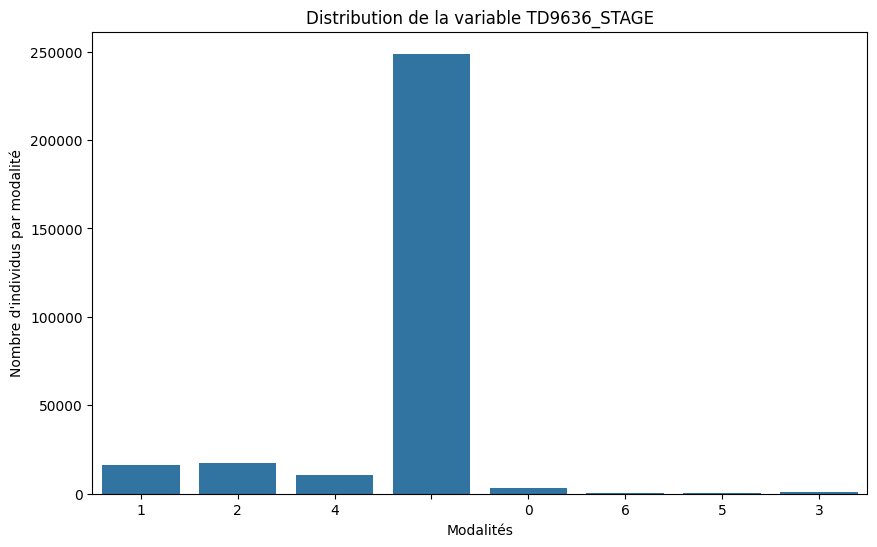

In [90]:
#The column we want to predict is TD9636_STAGE, lets take a look at it
print(f"Our target column is now of the {type(df['TD9636_STAGE'])} type\n")
print(f"This is how our target behave in the dataset : \n{df['TD9636_STAGE'].describe()}\n")
print(f"The values in our target column are {df.TD9636_STAGE.unique()}\n")
print(f"Below the value count inside the TD9636_STAGE column : \n{df.TD9636_STAGE.value_counts()}")
distribution('TD9636_STAGE', df)

When we will clean the dataset, it will also be important to manipulate also the columns we will need in our model :
- ISO_TIME : This column is really important as a storm evolve during the time. It will be effective to convert it as a .datetime() format.
- TD9636_STAGE : It is our target. For now its format is integer, and it seems fine for now. but we need to remove the " " values as it will probably make our future plotting not relevant.
- TD9636_LON and TD9636_LAT : are both longitude and latitude in deg north and east, so we need them into float in order to use it on a map.

In [91]:
#there is no missing value in the target column. Indeed the missing value is a space, lets replace the " " by the value "7"
filtered_df = df.copy()
filtered_df = filtered_df.loc[df["TD9636_STAGE"] != " "] #Here is the filtered one

#suggestion in case we have the following values " " : utilisation de regex pour " " "" "\n" "\t"
#filtered_df["TD9636_STAGE"].replace(r"^\s*$", "7", regex=True, inplace=True)

Now we have filtered the dataframe, by omitting the " " values in the new one.

## Variable "NATURE" univariate analysis
This variable is a combined storm type. This is assigned based on all available storm types.
We see that, based on the distribution of the target and the NATURE feature, we don't really have links between both.
Let's dig somewhere else.

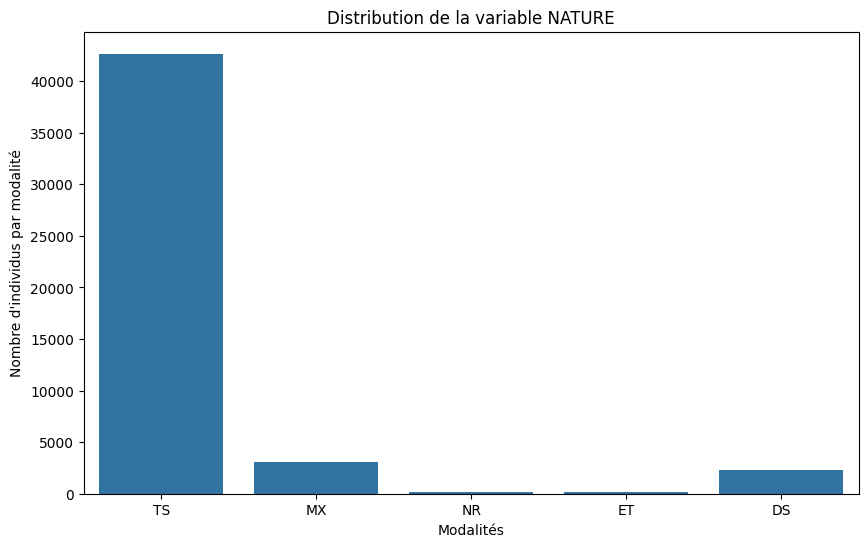

In [92]:
distribution("NATURE", filtered_df)

We see that the class TS is dominant.

## Variable "BASIN" univariate analysis 
The basins are geographical zones around the world (for instance North Atlantic, Asia, ...). It is then divided into "SUBBASIN" variable.

We see that after the replacement of the missing values in the target, no difference appear in the distribution of our target, regarding the missing values.

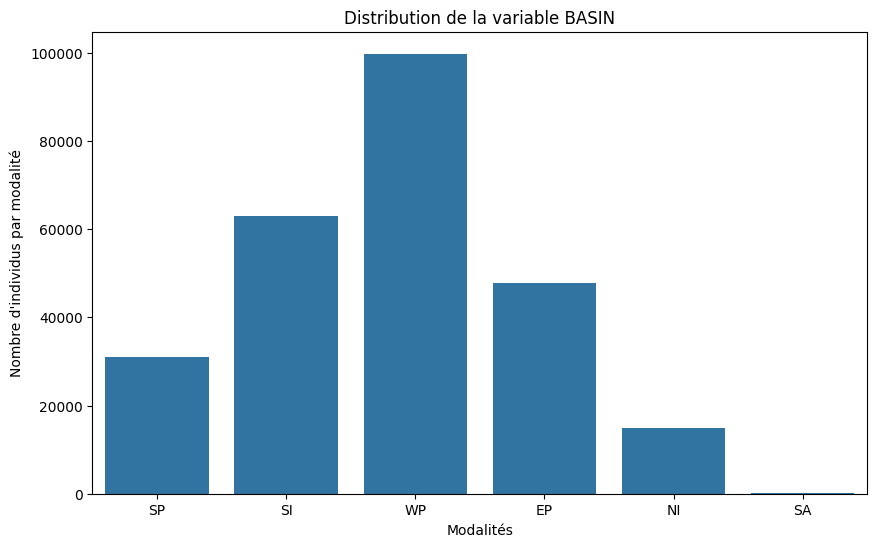

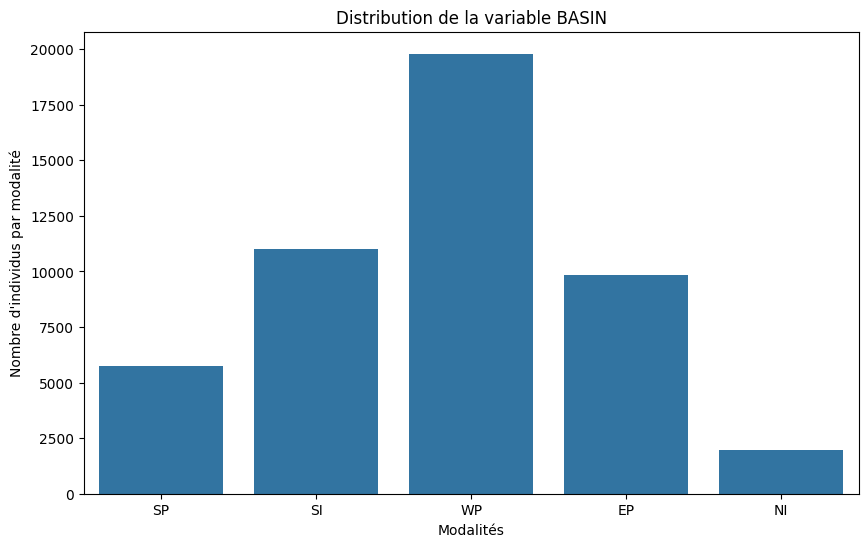

In [93]:
distribution("BASIN", df)
distribution("BASIN", filtered_df)

We see here that when we are comparing the original data set and the filtered one we have a slight change in the distribution (SI and EP seem to balance a bit) and we are also loosing one Basin.

## Variable "SEASON" univariate analysis 
Here we will have a look of the impact of the remplacement in the target column regarding the SEASON feature.

We notice that the recors of our target TD9636_STAGE hase only been made from 1980 to 1989. So we will only need this period of time in our study.

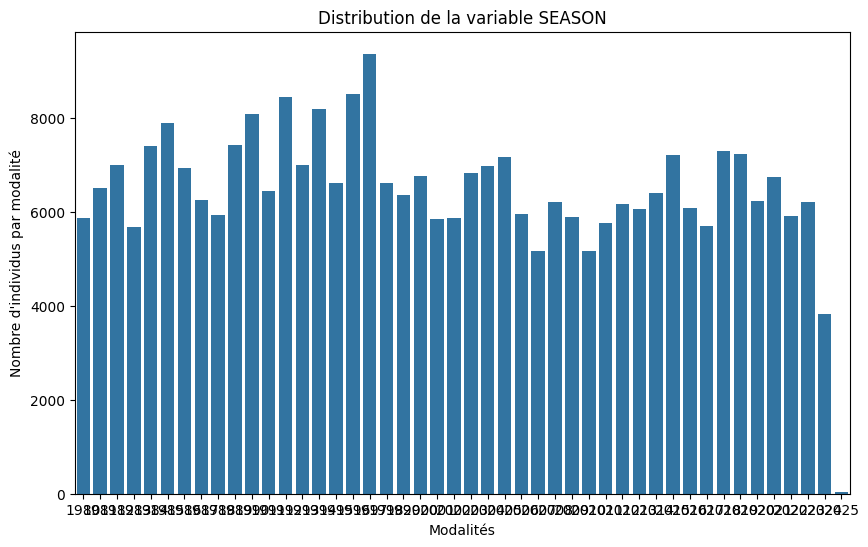

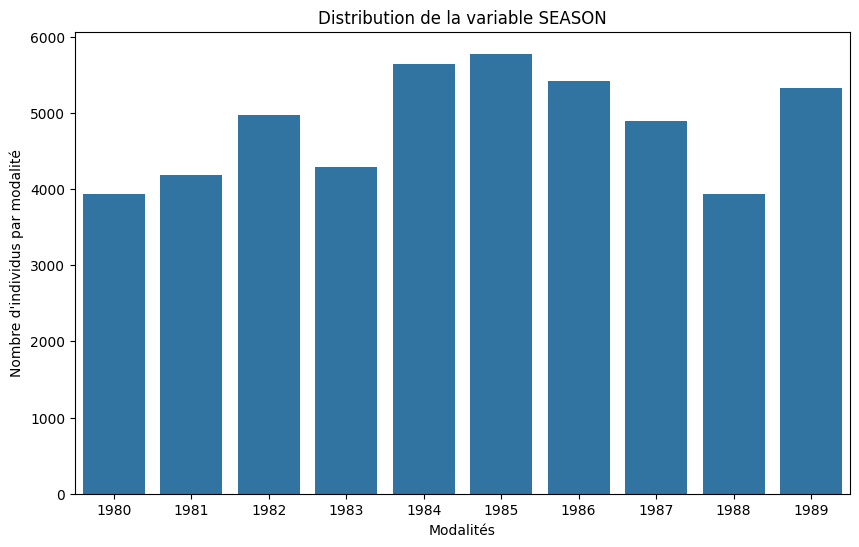

In [94]:
#The use of the filtered csv instead of the replaced csv is needed because on the new values created inside the replaced one.
distribution("SEASON", df)
distribution("SEASON", filtered_df)

## Variable "WMO_AGENCY" univariate analysis
This variable refers to the agency in charge af the monitoring of the basins.



The unique values in this variable are [' ' 'wellington' 'reunion' 'bom' 'cphc' 'tokyo' 'hurdat_epa' 'hurdat_atl'
 'newdelhi' 'nadi' 'atcf']


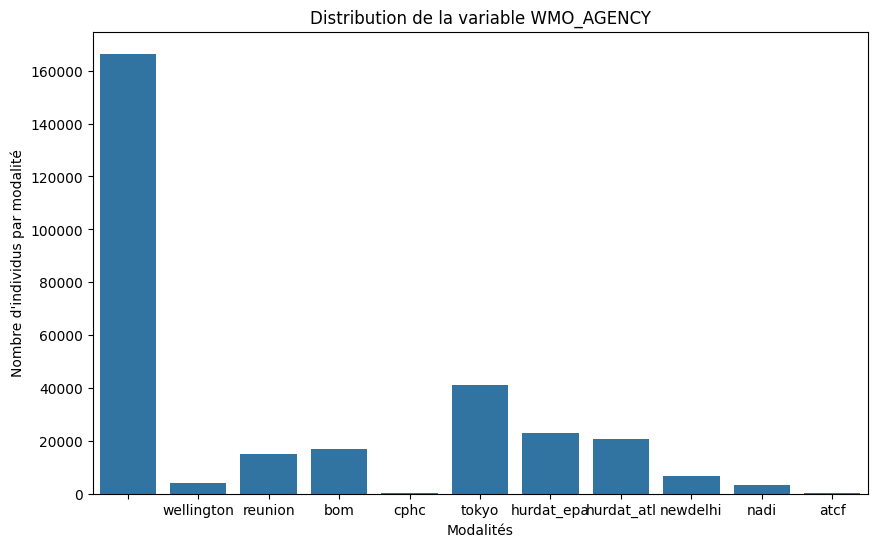

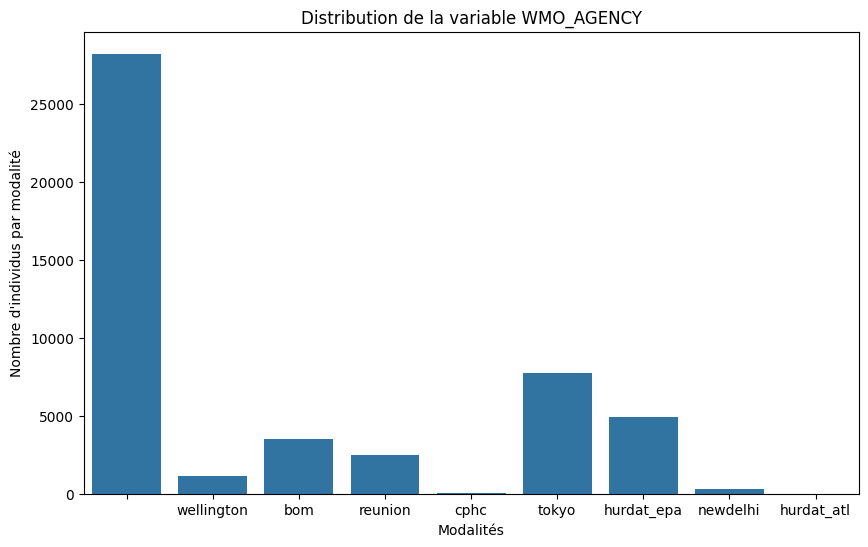

In [95]:
print(f"The unique values in this variable are {df['WMO_AGENCY'].unique()}")
distribution("WMO_AGENCY",df)
distribution("WMO_AGENCY",filtered_df)

We see here that we are losing one agency when using the filtered dataset, but the distrubution looks indetical. We just have less missing values due to the filtering.

In [96]:
df['SEASON'] = pd.to_numeric(df['SEASON'], errors='coerce')
df_reunion = df[df['WMO_AGENCY'] == 'reunion']
df_reunion_filtered = df_reunion[df_reunion['SEASON'] < 1993]

print("Nombre de lignes avec WMO_AGENCY='reunion' avant 1993 :", len(df_reunion_filtered))
print(df_reunion_filtered['SEASON'].value_counts().sort_index())

df_imd = df[df['WMO_AGENCY'] == 'newdelhi']
df_imd_filtered = df_imd[df_imd['SEASON'] < 1990]

print("\nNombre de lignes avec WMO_AGENCY='newdelhi' avant 1990 :", len(df_imd_filtered))
print(df_imd_filtered['SEASON'].value_counts().sort_index())

Nombre de lignes avec WMO_AGENCY='reunion' avant 1993 : 3803
SEASON
1980    274
1981    314
1982    289
1983    126
1984    429
1985    293
1986    297
1987    233
1988    322
1989    357
1990    319
1991    181
1992    369
Name: count, dtype: int64

Nombre de lignes avec WMO_AGENCY='newdelhi' avant 1990 : 578
SEASON
1982    139
1983     61
1984     70
1985     95
1986     24
1987    107
1988     40
1989     42
Name: count, dtype: int64


Indeed, the documentation of the dataset is correct. We actually have the agency recently created that will be retroactively in charge of some records, but are in fact created after those.

## Missing values analysis
We will here try to identify all the missing values to start having a reflexion on how to handle them.

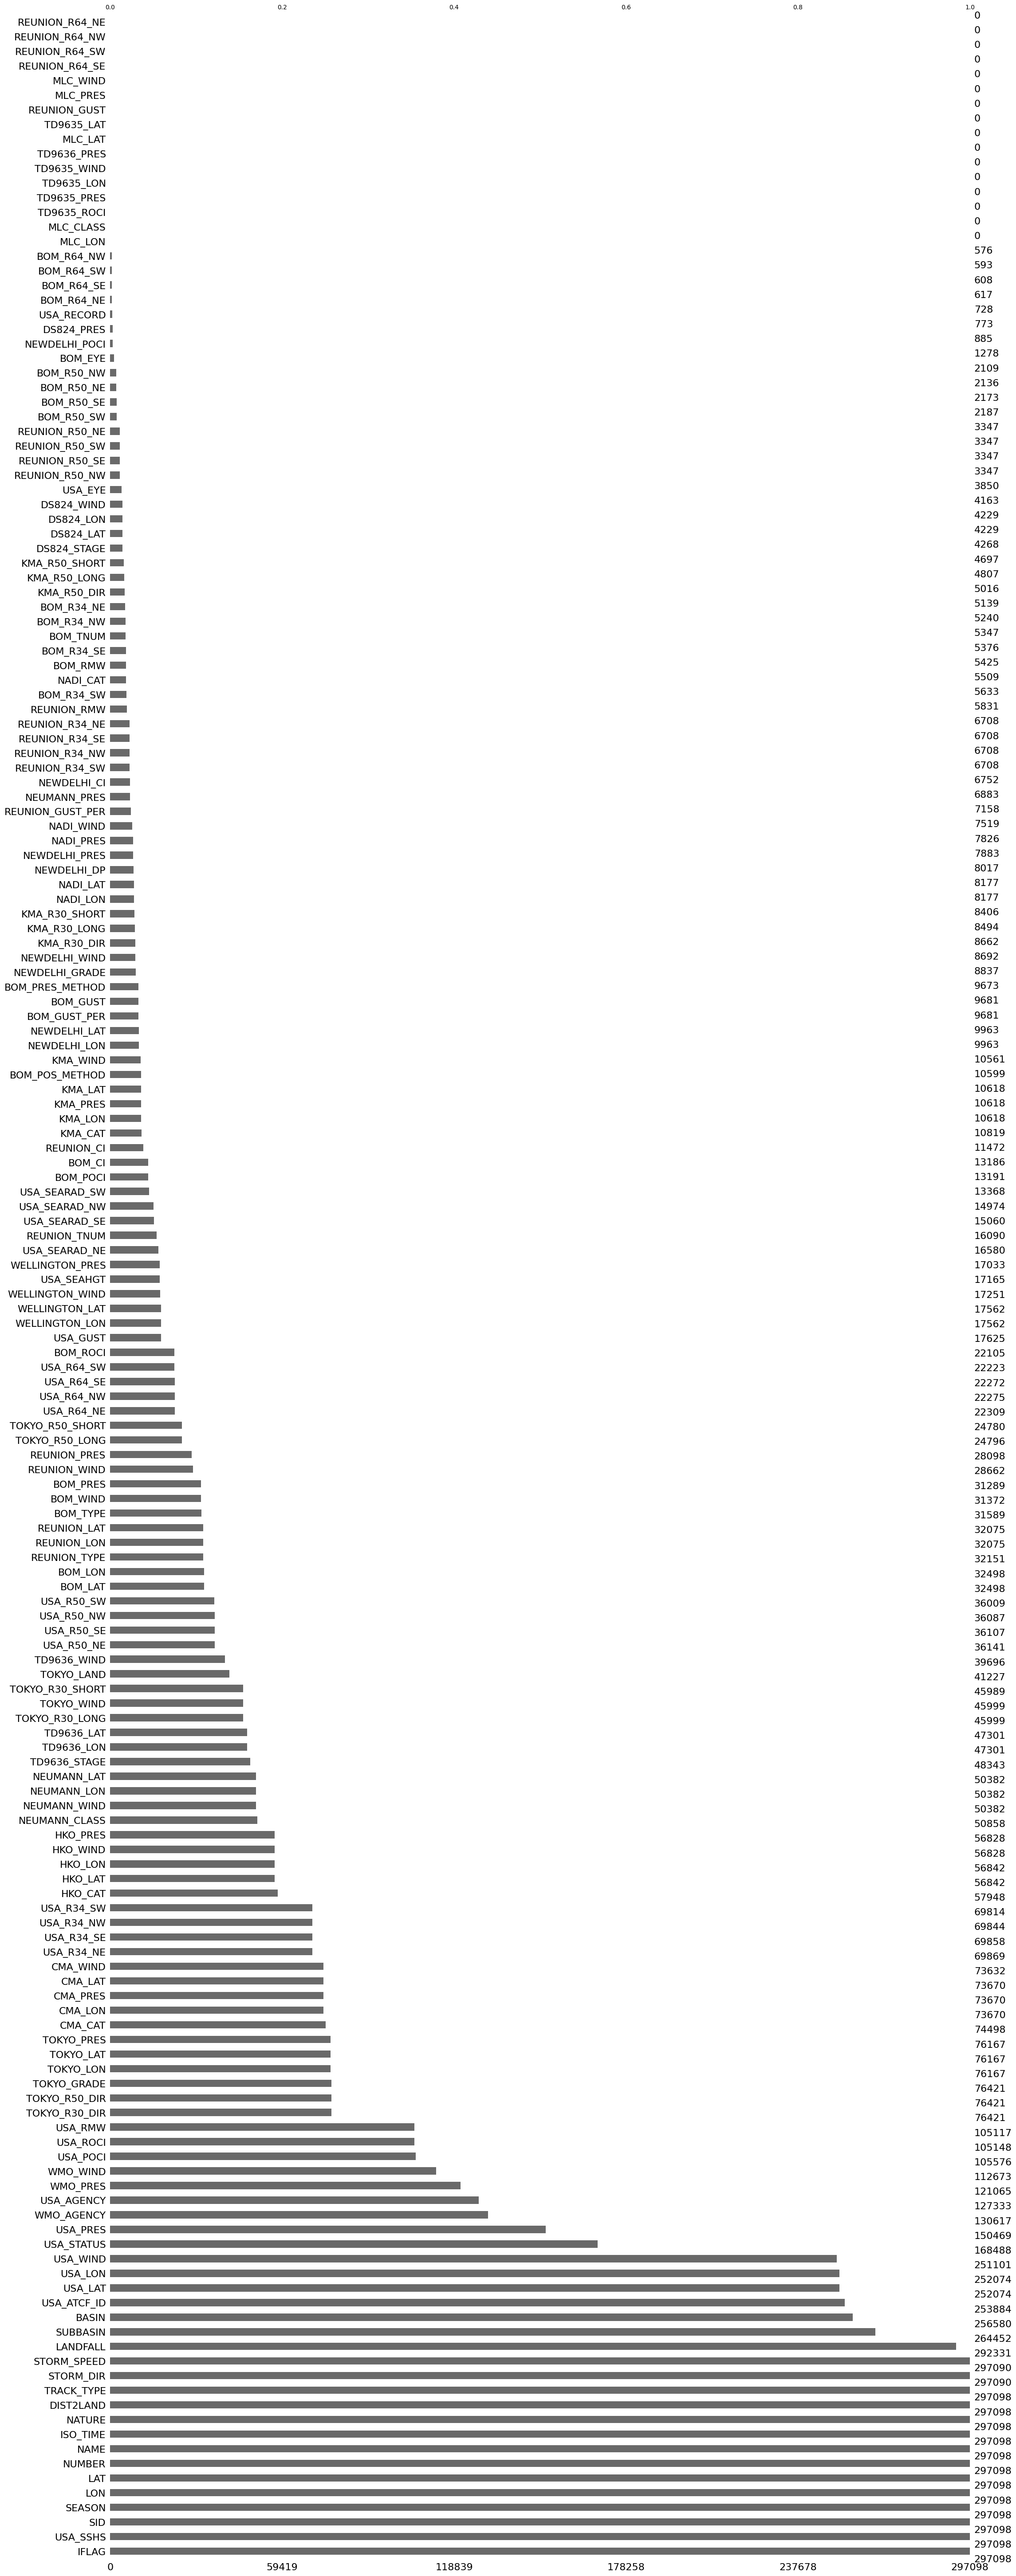

In [97]:
#A new copy of the dataset is here created because we still don't know how to handle the final clean dataset
#We will get reid of all of them soon
miss_values_df = df.copy()
miss_values_df.replace(to_replace=" ", value=pd.NA, inplace=True)

plt.figure(figsize=(10,6))
msno.bar(miss_values_df, sort="descending")
plt.show()

Indeed a lot of missing values are in fact " ", which gives an illusion of missing values.

Now that we have a clear representation of the missing values, we can notice that even for other variable than our target, we have a lot of "blanks". This can be explain by the fact that all this dataset is an union of records that have different observation agency source, the latter of which may be equipped differently, or take other criterias in consideration.


# In depth univariate analysis
We will take more time here to study all the different features that seems pertinent on our analysis and see how they are pertinent in our model. Some treatment in the data will need to be done in this step to ensure consistency in the analysis and in the plotting. 

As in the previous steps we used different dataframes, where missing values are handled differently, we will need here to have more consitency in the treatment of the data.

## Variable "TD9636_STAGE" univariate analysis, and understanding of our target
This variable will then need to be used in a heatmap and a geographic reprensentation so we will convert it into float.

Let's plot it and try to see if we can notice something from the analysis of this column.

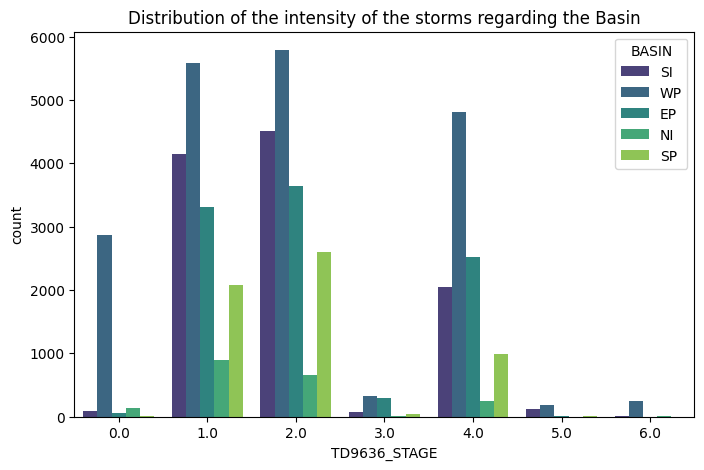

On the Data we have 48343 values that has a point to analyse. Among them, the repartition is at is follow 
TD9636_STAGE
2.0    17204
1.0    16028
4.0    10623
0.0     3156
3.0      742
5.0      331
6.0      259
Name: count, dtype: int64 
Wich gives in percentage TD9636_STAGE
2.0    35.587365
1.0    33.154748
4.0    21.974226
0.0     6.528350
3.0     1.534865
5.0     0.684691
6.0     0.535755
Name: count, dtype: float64


In [98]:
#convert the target into float type for a future use because now it is an object 
filtered_df["TD9636_STAGE"] = filtered_df["TD9636_STAGE"].astype(float)

#Class distribution of the intensity of the storms regardin the basin
plt.figure(figsize=(8,5))
sns.countplot(x="TD9636_STAGE", data=filtered_df, hue="BASIN", palette="viridis")
plt.title("Distribution of the intensity of the storms regarding the Basin")
plt.show()

#count of the distribution of the intensity of the storms and the relative information in percentage
total_intensité = len(filtered_df[filtered_df["TD9636_STAGE"] !=7]) #The value 7 will be excluded in the counts as we don't need to care of the corrupted records, they aren't relevant
nombre_intensités = filtered_df["TD9636_STAGE"][filtered_df["TD9636_STAGE"] !=7].value_counts()
print(f"On the Data we have {total_intensité} values that has a point to analyse. Among them, the repartition is at is follow \n{nombre_intensités} \nWich gives in percentage {(nombre_intensités / total_intensité) * 100}")

The repartition of the values in our target shows that we have way more frenquently a 1 or a 2 or 4 intensity storm than the others. Indeed, more thant 90% of the datas are in this range. However the nature of the dataset himself push us to relate more features together as a storm is "alive". So the time factor and the location one must be taken into account. 

We used in the histogram above the condition of the basin to try to evaluate if it has an impact regarding the number of storms and also the intesity of it. And as we see, it has quite a huge impact on the analysis. As we see the WP (Western North Pacific) is a basin that have more storms than the others. Which means that the regions in this area of the globe are more likely to have a storm.

### Spatial representation of the distribution of the intensity of the storms
Here is another way to represent the distribution of the intensity of the storms on a map to see where it hapen on the golbe.

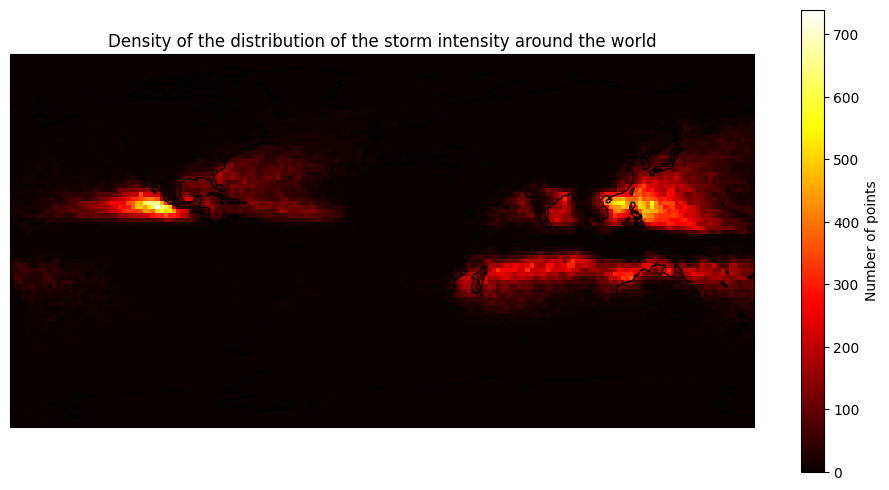

In [99]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.set_global()


lon_bins = np.linspace(-180, 180, 180)  
lat_bins = np.linspace(-90, 90, 90)    

plt.hist2d(df['LON'], df['LAT'], bins=[lon_bins, lat_bins], transform=ccrs.PlateCarree(), cmap='hot')
plt.colorbar(label="Number of points")

plt.title("Density of the distribution of the storm intensity around the world")
plt.show()

Add commentary of this representation

## Temporal variables analysis
As the data set is contruct as a timeline and we all know that a storm evolve with the time, we will take some time to identify the different temporal variables in the dataset, how they behave and how to handle them in order to ensure consitency in the analysis.

In [100]:
#convert the column ISO_TIME into .datetime() format
filtered_df["ISO_TIME"] = pd.to_datetime(filtered_df["ISO_TIME"], errors="coerce")
filtered_df['YEAR'] = filtered_df['ISO_TIME'].dt.year
filtered_df['MONTH'] = filtered_df['ISO_TIME'].dt.month
print(filtered_df["ISO_TIME"].dtype)

datetime64[ns]


### Analysis of the feature "ISO_TIME" regarding our model
As mentioned before, we only need to focus our analysis and our Machine Learning solution onto the target TD9636_STAGE. This beacon has made record for a period of time, let's see it more in depth.

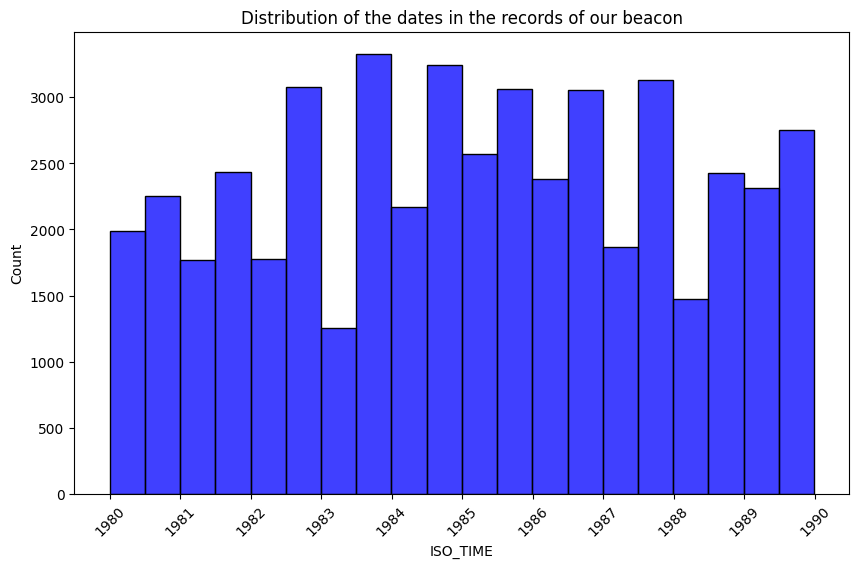

In [101]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["ISO_TIME"], kde=False, color="blue", bins=20)
plt.title("Distribution of the dates in the records of our beacon")
plt.xticks(rotation=45)
plt.show()

So here we can see that our beacon TD9636 has made records from 1980 to 1989. We then don't care about previous and followings dates.

### Analysis of the life of a storm
As we all know and mentioned before, a storm has a life. It starts somewhere with a given intensity and move along a path, with variations in some parameters. This can be interesting to indentify those parameters and how they behave.

Some stats about the storms
Number of storms : 793
Average lifetime (days) : 7.443673812526272
Median lifetime (days) : 6.875
Max lifetime (days) : 21.625


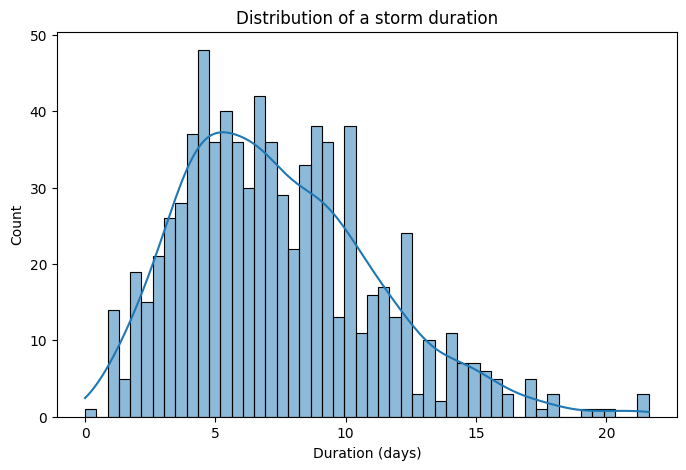

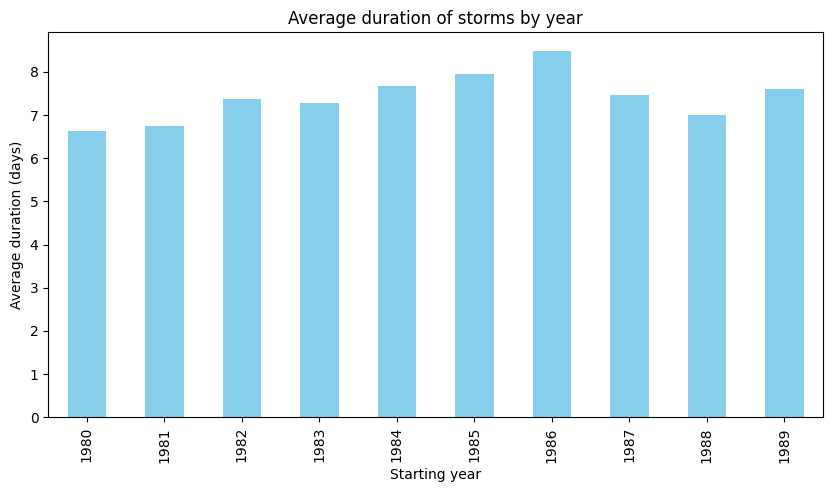

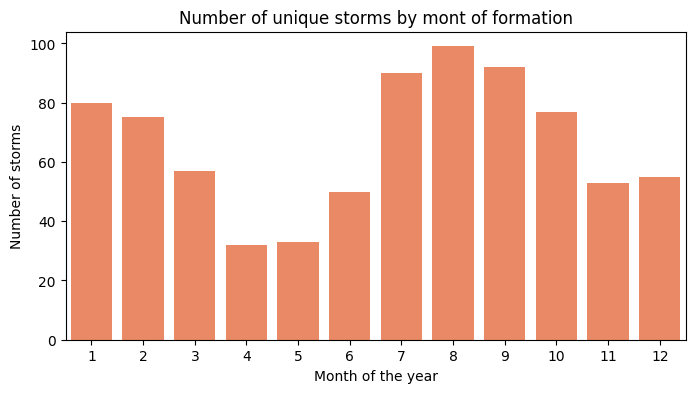

In [102]:
#Average lifetime of a storm
filtered_df = filtered_df.dropna(subset=['ISO_TIME'])

storm_times = filtered_df.groupby('SID')['ISO_TIME'].agg(['min', 'max'])

storm_times['duration_days'] = (storm_times['max'] - storm_times['min']).dt.total_seconds() / (3600 * 24)

print("Some stats about the storms")
print("Number of storms :", len(storm_times))
print("Average lifetime (days) :", storm_times['duration_days'].mean())
print("Median lifetime (days) :", storm_times['duration_days'].median())
print("Max lifetime (days) :", storm_times['duration_days'].max())

plt.figure(figsize=(8,5))
sns.histplot(data=storm_times, x='duration_days', bins=50, kde=True)
plt.xlabel("Duration (days)")
plt.title("Distribution of a storm duration")
plt.show()

storm_times['start_year'] = storm_times['min'].dt.year
storm_times['end_year'] = storm_times['max'].dt.year

annual_stats = storm_times.groupby('start_year')['duration_days'].mean()

plt.figure(figsize=(10,5))
annual_stats.plot(kind='bar', color='skyblue')
plt.title("Average duration of storms by year")
plt.xlabel("Starting year")
plt.ylabel("Average duration (days)")
plt.show()

# Saisonnalité: mois de début
filtered_df['start_month'] = filtered_df.groupby('SID')['ISO_TIME'].transform('min').dt.month
monthly_counts = filtered_df.groupby('start_month')['SID'].nunique().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, color='coral')
plt.title("Number of unique storms by mont of formation")
plt.xlabel("Month of the year")
plt.ylabel("Number of storms")
plt.show()

# Supplément d'idées:
#  - Durée vs intensité max (s'il existe une colonne WMO_WIND, par ex.)
#  - Durée par bassin (BASIN) ou par région
#  - Distribution des durées avant 1980 vs après 2000, etc.

Here we can notice that we have a seasonality for the storms, with more perturbations from July to October.

### Bivariate analysis of the variation of the storm instensity over the time
Lets go a bit further into the analysis of the intensity of the storms over the time.

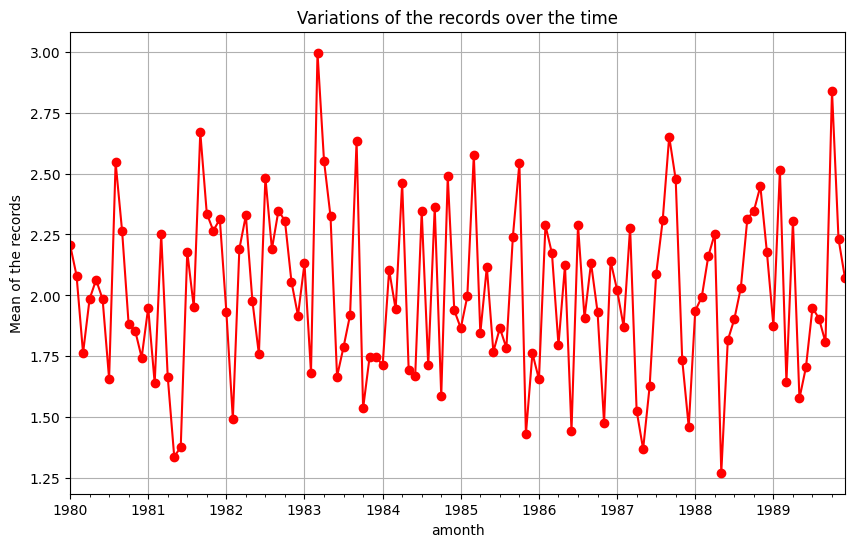

In [103]:
#Average of our target to avoid too much information
filtered_df["amonth"] = filtered_df["ISO_TIME"].dt.to_period("M")

temporal_mean = filtered_df.groupby('amonth')["TD9636_STAGE"].mean()

plt.figure(figsize=(10, 6))
temporal_mean.plot(kind="line", marker="o", color="red")
plt.title("Variations of the records over the time")
plt.ylabel("Mean of the records")
plt.grid(True)
plt.show()

We see here that we observe some redundancy in the records, in fact a schema is appearing. The average of those records are higher at some periods of the year and in a redundant way over the time. It confirm the seasonality that we observed in the previous step.

## Geographic variables analysis
As we did before, we will here take a look at the Geographic parameters inside the dataset. First we already identified LON and LAT regarding TD9636 and we will need to handle them as coordinates, so as float type.

In [104]:
#need to identify how the LON and LAT are handled
print(filtered_df["TD9636_LON"].dtype)
print(filtered_df["TD9636_LAT"].dtype)
#convert object to float(coordinates)
filtered_df["TD9636_LAT"] = pd.to_numeric(filtered_df["TD9636_LAT"], errors="coerce")
filtered_df["TD9636_LON"] = pd.to_numeric(filtered_df["TD9636_LON"], errors="coerce")
#handling Nan in coordinates
print(filtered_df[["TD9636_LON", "TD9636_LAT"]].isna().sum())

#We also have a general LON and LAT, lets see if we have less missing values here
#need to identify how the LON and LAT are handled 
print(filtered_df["LON"].dtype)
print(filtered_df["LAT"].dtype)
#convert object to float(coordinates)
filtered_df["LAT"] = pd.to_numeric(filtered_df["LAT"], errors="coerce")
filtered_df["LON"] = pd.to_numeric(filtered_df["LON"], errors="coerce")
#handling Nan in coordinates
print(filtered_df[["LON", "LAT"]].isna().sum())

object
object
TD9636_LON    1042
TD9636_LAT    1042
dtype: int64
float64
float64
LON    0
LAT    0
dtype: int64


### Univariate analysis of the features LON and LAT
Now that the format of the coordinates are handled, let's take a look at this parameter

         TD9636_LAT    TD9636_LON
count  47301.000000  47301.000000
mean       4.860206     61.557183
std       17.438667    109.460767
min      -50.000000   -180.000000
25%      -13.600000     43.000000
50%       12.000000    114.000000
75%       17.800000    140.400000
max       49.000000    180.000000


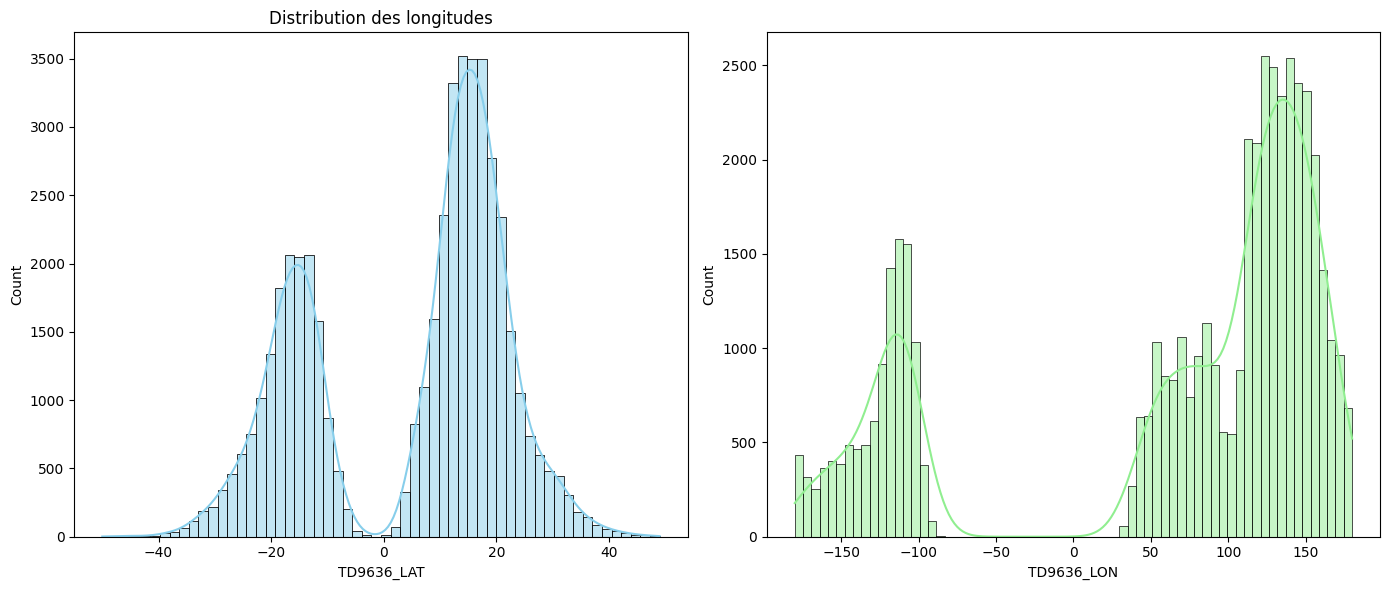

In [105]:
#boxplot of the distribution of LON and LAT
print(filtered_df[["TD9636_LAT", "TD9636_LON"]].describe())

fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.histplot(filtered_df["TD9636_LAT"], kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Distribution des latitudes")

sns.histplot(filtered_df["TD9636_LON"], kde=True, ax=axes[1], color="lightgreen")
axes[0].set_title("Distribution des longitudes")

plt.tight_layout()
plt.show()


This histogram show us that the reacord are ditributed in a similar way for LON and LAT, this means that a schema can be done regarding the probability of a storm at a given point of the world.

### Bivariate analysis of the Geographic coordinates, regarding our target
We will try here to identify the different relationships that may exist between the coordinates and the intensity of the storm.

Let's first look together the relationships betwenn LON and LAT regarding our target.

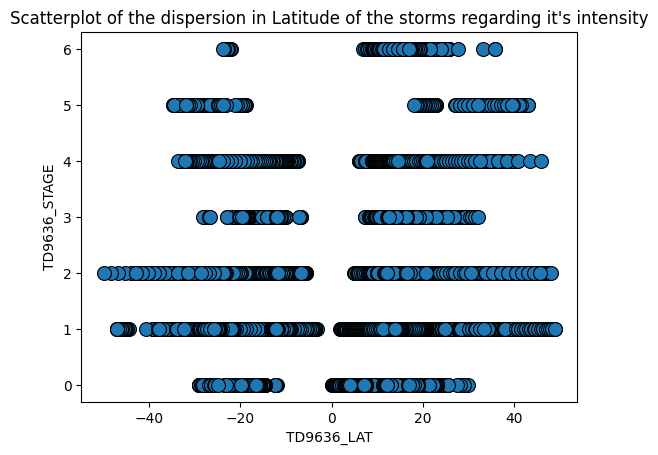

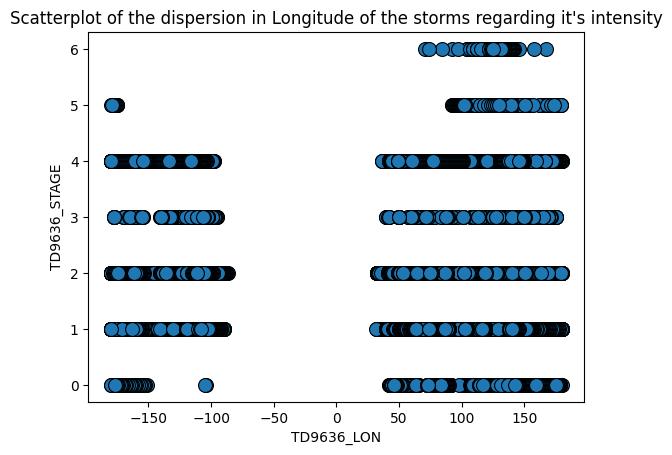

In [106]:
#Bivariate analysis
#scatterplot of the dispersion in Latitude of the storms regarding it's intensity
sns.scatterplot(x="TD9636_LAT", y="TD9636_STAGE", data=filtered_df, s=100, edgecolor="black")
plt.title("Scatterplot of the dispersion in Latitude of the storms regarding it's intensity")
plt.show()

#scatterplot of the dispersion in Longitude of the storms regarding it's intensity
sns.scatterplot(x="TD9636_LON", y="TD9636_STAGE", data=filtered_df, s=100, edgecolor="black")
plt.title("Scatterplot of the dispersion in Longitude of the storms regarding it's intensity")
plt.show()

Those two plots are just confirming our previous constatation about the geographic repartition of the storms. Its stays a bit similar, no matter the intensity.

### Spatial representation of the distribution of the records
Here is an interractive map to represent the storms. The slider on the top help us to manage the period of time we want to appear on the map (the two boxes are for the same purpose but with a manual input)

The map has as feature :
- Automatic update of the points when changing the dates into the period slider (or boxes). (Note that in some case this may take time).
- There is an automatic link made between records to track the path of the storm. It can be filtered inside the code (to change the max distance between two points and max time between two records. Here is 300km and 48hours).
- The dots are the records and are coulored regarding their intensity.
- A mouseover on a point gives us more information about this record.

In [107]:
#création d'un slider et de ses limites pour ISO TIME
min_date, max_date = filtered_df['ISO_TIME'].min(), filtered_df['ISO_TIME'].max()

interractive_slider = widgets.SelectionRangeSlider(
    options=[date.strftime("%Y-%m-%d") for date in pd.date_range(min_date, max_date)],
    index=(0,len(pd.date_range(min_date, max_date)) - 1),
    description="Date Range",
    orientation="horizontal",
    layout={"width": "80%"}
)

#cration color map entre 0 et 6 pour la target
colormap = cm.linear.viridis.scale(0,6)

#possibilité de mettre à jour la carte en fonction de la plage de dates séléctionnée
def update_map(date_range):
    """
    Argument : la plage de date du slider
    retrun : la carte
    """

    start_date, end_date = pd.to_datetime(date_range)
    filtered_map = filtered_df[(filtered_df['ISO_TIME'] >= start_date) & (filtered_df['ISO_TIME'] <= end_date)]

    #création de la map
    carte = folium.Map(location=[filtered_df['LAT'].mean(), filtered_df['LON'].mean()], zoom_start=5)
    
    #création du cluster de points et ajout des points from target
    map_cluster = MarkerCluster().add_to(carte)
    for _, row in filtered_map.iterrows():
        folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            radius=5,
            color=colormap(row['TD9636_STAGE']),
            fill=True,
            fill_color=colormap(row['TD9636_STAGE']),
            fill_opacity=0.8,
            popup=f"Date: {row['ISO_TIME'].date()}<br>Target: {row['TD9636_STAGE']}", #info au clic de la souris
            tooltip=f"Date: {row['ISO_TIME'].date()}<br>Target: {row['TD9636_STAGE']}<br>Location: {row['BASIN']}<br>Nature: {row}" #info au mouseover
        ).add_to(map_cluster)
    
    #relier les points ajoutés pour une meilleure lisibilité, et dans l'ordre du temps
    filtered_map = filtered_map.sort_values("ISO_TIME")

    #coordinates = filtered_map[["TD9636_LAT", "TD9636_LON"]].values.tolist()
    #filtrer les lignes pour ne connecter que les points proches (attention pour v1 avec 1 seul filtre, remplacer nom de la fonction et le 1er paramètre par la var coordinates)
    filtered_lines = filter_close_points_with_time(filtered_df, max_distance_km=300)

    #ajouter les segments filtrés
    for segment in filtered_lines:
        folium.PolyLine(segment, color="blue", weight=2.5, opacity=0.7).add_to(carte)

    #ajout d'une légende
    colormap.caption = "TD9636 Value"
    carte.add_child(colormap)

    return carte

#fonction d'affichage interractif
def interractive_map(date_range):
    display(update_map(date_range))

#de part l'immense taille du data set et éviter qu'il y ait trop de points reliés pour rien, on va ajouter une fonction pour créer un seuil qui ne connectera que les points proches

#Afin d'éviter que la segmentation ne relie deux points proches en distance mais pas en ISO_TIME, on ajoute un nouveau filtre
def filter_close_points_with_time(filtered_csv, max_distance_km=1000, max_time_diff_hours=12):
    
    lines = []

    #Sort ISO_TIME to iterate in a chronological order, and create a new index from this sorting to avoid any index conflict
    filtered_csv = filtered_csv.sort_values("ISO_TIME").reset_index(drop=True)

    #goal is to go in the points of the DF to see 1. if they are close by Geographically 2. if they are close by in the Timeline
    for i in range(len(filtered_csv) - 1): #iterate until the penultiem element to compare each element with the previous one
        point1 = (filtered_csv.loc[i, "LAT"], filtered_csv.loc[i, "LON"]) #access the LAT and LON at i point
        point2 = (filtered_csv.loc[i + 1, "LAT"], filtered_csv.loc[i + 1, "LON"]) #access the LAT and LON at i+1 point, gives two successive points
    #After several tests we are using LON and LAT instead of TD9636_... because of the NaN in the second one.

        time_diff = (filtered_csv.loc[i + 1, "ISO_TIME"] - filtered_csv.loc[i, "ISO_TIME"]).total_seconds() / 3600 #the operation return a timedelta, .total_second convert into seconds, and /3600 for hours
        distance = geodesic(point1, point2).km #function to mesure a distance between 2 points, in km

        if distance < max_distance_km and time_diff < max_time_diff_hours: #check if max_distance and max_time are respected
            lines.append([point1, point2]) #if yes, then the coordinates the point is added to the line
    
    return lines



widgets.interactive(interractive_map, date_range=interractive_slider)

interactive(children=(SelectionRangeSlider(description='Date Range', index=(0, 3650), layout=Layout(width='80%…

### Spatial reprensentation of the trajectories of the storms
Here we will see, from a global point of view, during the period of time where TD636 recorded data, the trajectories of the storms to see if they have a prefered path.

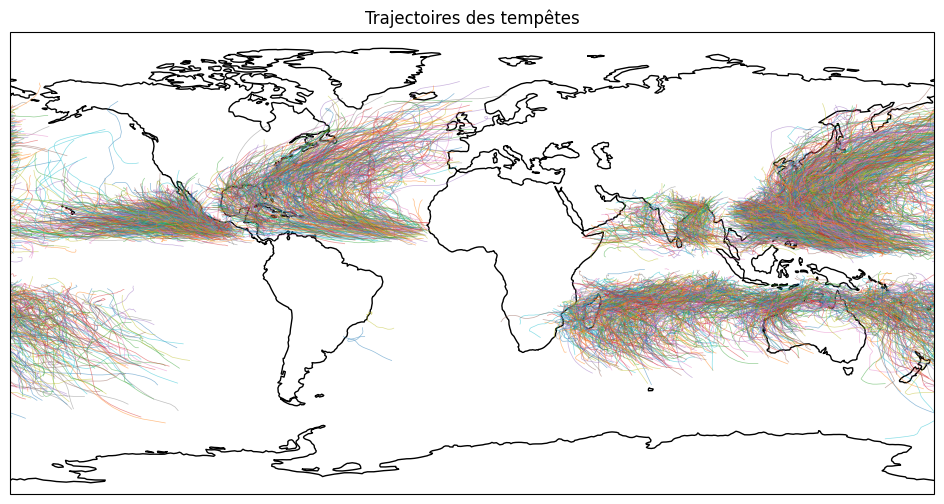

In [108]:
grouped = df.groupby('SID')

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.set_global()

for sid, group in grouped:
    group = group.sort_values('ISO_TIME')
    plt.plot(group['LON'], group['LAT'], transform=ccrs.PlateCarree(), linewidth=0.5, alpha=0.5)

plt.title("Trajectoires des tempêtes")
plt.show()

# Multivariate analysis and other interesting features
We already indentified some mandatory features in our model. We now need to study more features to see if they are relevant for se base or for the others features we may add to the model

## Representation of the wind speed in the storms
The wind speed is a factor that can impact a lot for a storm. Indeed, it can raise its movement speed and maybe some other parameters that we will try to indentify

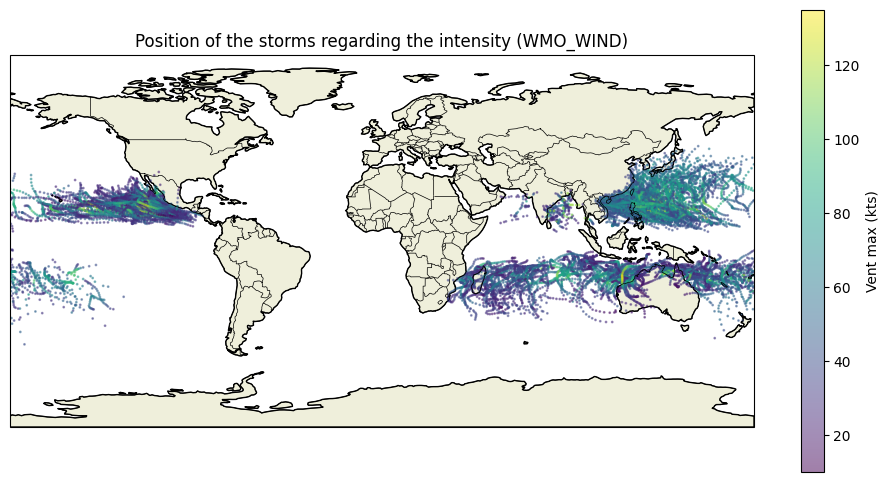

In [109]:
#To avoid errors we need to handle the wind speed into numbers instead of objects
filtered_df['WMO_WIND'] = pd.to_numeric(filtered_df['WMO_WIND'], errors='coerce')


norm = mcolors.Normalize(vmin=filtered_df['WMO_WIND'].min(), vmax=filtered_df['WMO_WIND'].max(), clip=True)
cmap = plt.cm.viridis  

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.set_global()

scatter = plt.scatter(
    filtered_df['LON'], filtered_df['LAT'], 
    c=filtered_df['WMO_WIND'], cmap=cmap, norm=norm, 
    s=1, transform=ccrs.PlateCarree(), alpha=0.5
)
plt.colorbar(scatter, label="Vent max (kts)")
plt.title("Position of the storms regarding the intensity (WMO_WIND)")
plt.show()

## Distribution of the storms regarding the coastal distance of the storms
We will try to see here if we are more likely to have a storm in the middle of the ocean compared to the land

In [110]:
filtered_df['DIST2LAND'] = pd.to_numeric(filtered_df['DIST2LAND'], errors='coerce')
df_dist = filtered_df.dropna(subset=['DIST2LAND'])

count_under_100 = (df_dist['DIST2LAND'] < 100).sum()
print(f"Number of observations at < 100 km of the sea coast : {count_under_100}")


bins = [0, 100, 200, 500, np.inf]
labels = ["<100km", "100-200km", "200-500km", "500km+"]
df_dist['DIST_CAT'] = pd.cut(df_dist['DIST2LAND'], bins=bins, labels=labels)

print("\nDistribution of the observations by distance class :")
print(df_dist['DIST_CAT'].value_counts())

df_min_dist = df_dist.groupby('SID')['DIST2LAND'].min().reset_index(name='MIN_DIST2LAND')
tempetes_under_100 = (df_min_dist['MIN_DIST2LAND'] < 100).sum()
print(f"\nNumber of storms that have been at <100 km of the sea coast : {tempetes_under_100}")

Number of observations at < 100 km of the sea coast : 5318

Distribution of the observations by distance class :
DIST_CAT
500km+       29024
200-500km    10528
100-200km     3413
<100km        3029
Name: count, dtype: int64

Number of storms that have been at <100 km of the sea coast : 391


## Multivariate analysis
The nature itself of the dataset push us to try to correlate all the parameters we have seen above to try to establish the schema.

First we will try a correlation matrix to see the linearity of the relation between LON, LAT and STAGE

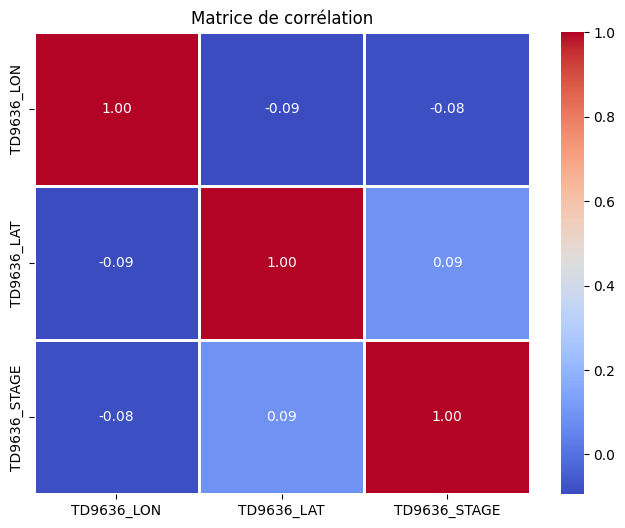

In [111]:
#Heatmap de la matrice de corrélation
corr = filtered_df[["TD9636_LON", "TD9636_LAT", "TD9636_STAGE"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=1)
plt.title("Matrice de corrélation")
plt.show()

We see that the matrix is arrange in a symetric way that means that we have a relation between these three parameters

# =================================================================  Il s'agit d'un premier jet de la préparation des données et du test de modèles. Mais tout ceci va être modifié pour essayer d'améliorer tout ça.  =================================================================

# Préparation du jeu de données

## Nettoyage du jeu de données

## Feature engineering

### Variables temporelles

Création d'une variable de début de tempête et de l'âge de la tempête en cours

In [112]:
filtered_df['start_date'] = filtered_df.groupby('SID')['ISO_TIME'].transform('min')
filtered_df['age_hours'] = (filtered_df['ISO_TIME'] - filtered_df['start_date']).dt.total_seconds() / 3600

In [113]:
variables_temporelles = ["start_date","age_hours","SEASON","ISO_TIME","YEAR","MONTH","start_month"]

In [114]:
variable_cible = 'TD9636_STAGE' 


In [115]:
filtered_df = filtered_df.dropna(subset=[variable_cible])


In [116]:
df_temporel = filtered_df[variables_temporelles + [variable_cible]].copy()


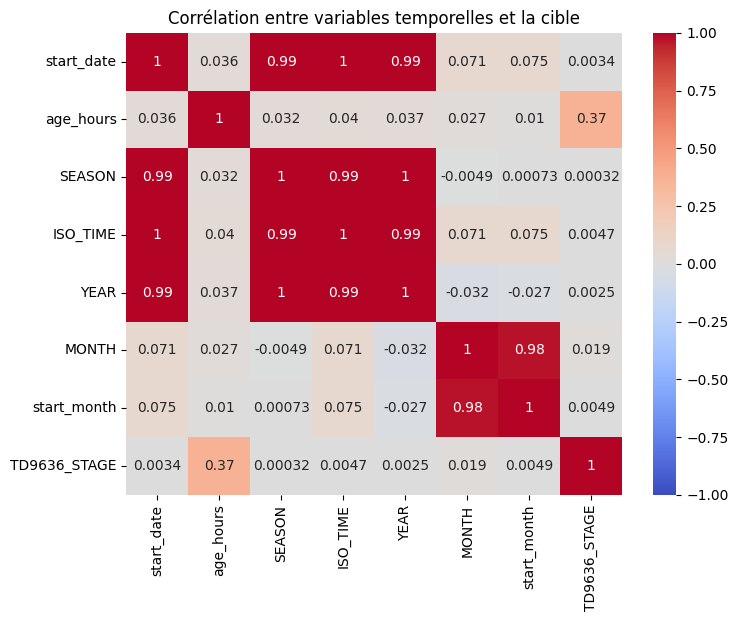

In [117]:
df_temporel[variable_cible] = pd.to_numeric(df_temporel[variable_cible], errors='coerce')
corr_mat = df_temporel.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Corrélation entre variables temporelles et la cible")
plt.show()

ON remarque que la seule variable temporelle qui semble être correllée avec la variable cible est la variable age_hours que nous avons créé
Nous allons essayer de confirmer cela via un random forest

In [118]:
df_temporel = df_temporel.drop(columns=['start_date', 'ISO_TIME'])
variables_temporelles = ["age_hours","SEASON","YEAR","MONTH","start_month"]

       feature  importance
0    age_hours    0.637587
4  start_month    0.096378
3        MONTH    0.092054
2         YEAR    0.087571
1       SEASON    0.086410


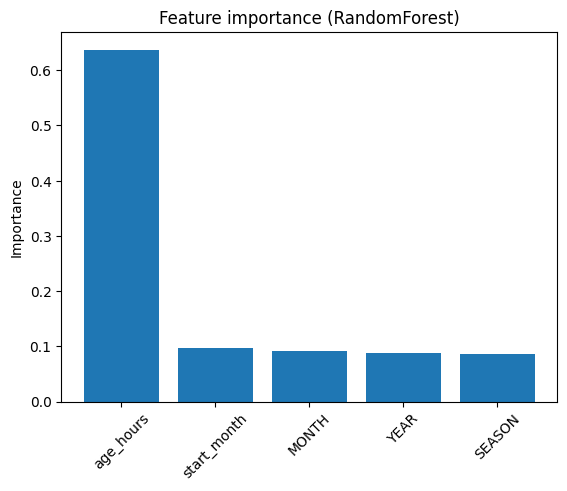

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_temporel[variable_cible] = le.fit_transform(df_temporel[variable_cible])


X = df_temporel[variables_temporelles]
y = df_temporel[variable_cible]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importance_variables_temporelles = rf.feature_importances_
df_importance_variables_temporelles = pd.DataFrame({
    'feature': variables_temporelles,
    'importance': importance_variables_temporelles
}).sort_values('importance', ascending=False)

print(df_importance_variables_temporelles)

plt.bar(df_importance_variables_temporelles['feature'], df_importance_variables_temporelles['importance'])
plt.title("Feature importance (RandomForest)")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

Le Random forest nous confirme bien l'importance d'une seule variable qui est celle de l'âge de la tempête en heures. Nous allons donc supprimmer les autres

In [120]:
variables_to_drop = ["ISO_TIME","start_date","SEASON","YEAR","MONTH","start_month"]
filtered_df = filtered_df.drop(columns = variables_to_drop)

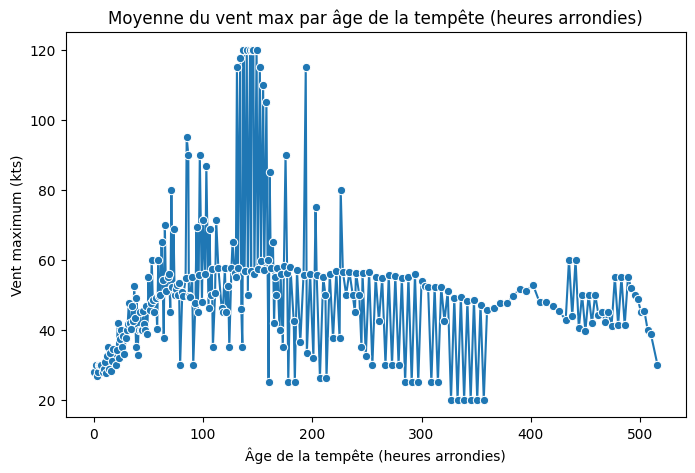

In [121]:
df_plot = filtered_df.groupby('age_hours')['WMO_WIND'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.lineplot(data=df_plot, x='age_hours', y='WMO_WIND', marker='o')
plt.title("Moyenne du vent max par âge de la tempête (heures arrondies)")
plt.xlabel("Âge de la tempête (heures arrondies)")
plt.ylabel("Vent maximum (kts)")
plt.show()

### Mutualisation des variables de localisation en une seule variable

Nous remarquons que certaines variables sont les mêmes mais nommées par zones. Par exemple nous pouvons nous séparer de toutes les variables de latitude et longitude en dehors des variables globales, car cela fait doublon.

In [122]:
filtered_df[["TD9636_LAT","TD9636_LON","LAT","LON"]].sample(20)

,TD9636_LAT,TD9636_LON,LAT,LON
35663,17.4,125.1,17.3,125.0
48537,-38.0,77.0,-37.0,75.3
15221,18.4,88.3,18.5,88.4
48339,-23.2,64.8,-23.3,64.6
40576,-20.2,40.9,-20.3,41.0
42340,-18.8,88.0,-18.4,87.5
66587,14.9,80.3,14.8,80.3
1613,-13.6,175.7,-13.6,175.5
54887,-14.4,69.3,-14.4,69.5
27114,-10.3,103.3,-10.4,103.3


Les TD_9636 LAT et LON ne seront pas gardées car elles ont des valeurs manquantes

In [123]:
filtered_df = filtered_df.drop(columns=[col for col in filtered_df.columns if col.endswith('_LON') or col.endswith('_LAT')])
print(f"Il reste {filtered_df.shape[1]} variables")

Il reste 144 variables


### Variable WMO_WIND

Il s'agit de la vitesse maximale du vent soutenu enregistrée par l'agence météorologique officielle (WMO). Le problème est que les périodes d'échantillonage sont différentes en fonctiond es zones (1min ou 3 min ou 10min). Donc la variable doit être corrigée pour que les différentes zones soient comparables. Pour cela nous avons effectué des recherches sur le sujet, et nous sommes tombé sur un article scientifique qui explique comment corriger ce problème en appliquant des ratios à la variable en fonciton de la localisation de la tempête et en fonction de la durée d'échantillonage. \
Voici le lien :  \
https://www.systemsengineeringaustralia.com.au/download/WMO_TC_Wind_Averaging_27_Aug_2010.pdf

Il s'agit de la table 1.1

In [124]:
# Définition d'une fonction pour déterminer la période d'échantillonnage selon l'agence
def determine_averaging_period(agency):
    mapping = {
        'hurdat_atl': '1min',
        'hurdat_epa': '1min',
        'cphc': '1min',
        'tokyo': '10min',
        'newdelhi': '3min',
        'reunion': '10min',
        'bom': '10min',
        'nadi': '10min',
        'wellington': '10min'
    }
    return mapping.get(agency, '10min')  # Valeur par défaut à 10 min si non précisé

# Fonction pour appliquer les ratios de conversion selon la localisation et la durée d'échantillonnage
def apply_wind_conversion(row):
    dist = row['DIST2LAND']
    wind_speed = row['WMO_WIND']
    agency = row['WMO_AGENCY']

    # Déterminer la durée d'échantillonnage
    avg_period = determine_averaging_period(agency)

    # Déterminer la catégorie d'exposition en fonction de DIST2LAND
    if dist > 20:
        exposure_ratios = {'1min': 1, '3min': 1, '10min': 1.05}
    elif dist <= 1:
        exposure_ratios = {'1min': 1, '3min': 1.10, '10min': 1.16}
    else:
        exposure_ratios = {'1min': 1, '3min': 1.05, '10min': 1.11}

    return wind_speed * exposure_ratios[avg_period]


filtered_df['WMO_WIND_ADJUSTED'] = filtered_df.apply(apply_wind_conversion, axis=1)

Comme dit juste avant les ratios sont attribués par rapport à la durée d'échantillonage et par rapport à la localisation (c'est à dire si la tempête est en mer ou proche de la côte. Pour savoir cela nous pouvons nous appuyer sur la variable DIST2LAND).

### Les différentes mesures de vitesse de vent

Nous essayons de comprendre la relation entre les différentes variables, notamment la différence entre WMO_WIND et TD9636_WIND

In [125]:
filtered_df[["TOKYO_WIND","USA_WIND","HKO_WIND","CMA_WIND","NEUMANN_WIND","TD9636_WIND","WMO_WIND","SID","NAME","BASIN","SUBBASIN","USA_WIND"]].sample(5)


,TOKYO_WIND,USA_WIND,HKO_WIND,CMA_WIND,NEUMANN_WIND,TD9636_WIND,WMO_WIND,SID,NAME,BASIN,SUBBASIN,USA_WIND
46466,,,,,,,NaN,1986308N11090,UNNAMED,NI,BB,
51129,95,115,105,106,,114,NaN,1987231N10159,DINAH,WP,MM,115
6224,,15,,,,18,NaN,1980349N10138,ED,WP,MM,15
54111,,108,,,110,109,NaN,1988006S05182,ANNE,SP,MM,108
34947,,,,,,,NaN,1985097S09076,HELISAONINA,SI,MM,


WMO_WIND = mesure officielle (selon l’agence WMO correspondante), mais la période de moyennage varie selon la région (1, 3 ou 10 minutes), ce qui peut compliquer la comparaison directe entre différentes zones. \
TD9636_WIND = estimation (subjective) de la vitesse maximale instantanée, homogénéisée sur une période de 1 minute, mais avec moins de garanties « officielles » et plus d’incertitudes (d’où la mise en garde sur l’interprétation).

Idées : On peut se servir de WMO_WIND_ADJUSTED en premier que l'on ajuste avec les ratios trouvés, et on peut compléter des NaN Par des valeurs de TD9636_WIND quand il y en a.
Le reste des NaN peuvent être complétés par les valeurs de avant et après dans la chronologie de la tempête

In [126]:
# Exécution de l'idée
# Remplaçage des premières valeurs manquantes par les valeurs de TD936_WIND 
filtered_df['WMO_WIND_ADJUSTED_COMPLETED'] = filtered_df['WMO_WIND_ADJUSTED'].fillna(filtered_df['TD9636_WIND'])

In [127]:
#Remplaçage des dernières valeurs manquantes par les moyennes de la première valeur non nulle précédente et suivante.
filtered_df['WMO_WIND_ADJUSTED_COMPLETED'] = pd.to_numeric(
    filtered_df['WMO_WIND_ADJUSTED_COMPLETED'], 
    errors='coerce'
)

# Amélioration : quand plusieurs valeurs NaN d'affilées faire montée ou descente progressive des valeurs.

In [128]:
filtered_df = filtered_df.sort_values(by=['SID', 'age_hours'])

filtered_df['forward'] = filtered_df.groupby('SID')['WMO_WIND_ADJUSTED_COMPLETED'].ffill()
filtered_df['backward'] = filtered_df.groupby('SID')['WMO_WIND_ADJUSTED_COMPLETED'].bfill()

def fill_value(row):
    original = row['WMO_WIND_ADJUSTED_COMPLETED']
    if not pd.isna(original):
        return original
    
    f = row['forward']
    b = row['backward']
    
    if pd.isna(f) and pd.isna(b):
        return np.nan    
    if pd.isna(b):
        return f    
    if pd.isna(f):
        return b    
    return (f + b) / 2

filtered_df['WMO_WIND_ADJUSTED_COMPLETED'] = filtered_df.apply(fill_value, axis=1)
filtered_df.drop(columns=['forward', 'backward'], inplace=True)

Nous décidons de ne garder que WMO_WIND_ADUJUSTED_COMPLETED parmis les variables de vent. En effet, il s'agit d'une amélioration des variables WMO_WIND_ADJUSTED, WMO_WIND et TD9636_WIND. De plus les autres variables de vent correspodent soit à une autre zone que celle de la tempête, soit à la zone de la tempête, mais ce qui fais doublon.

In [129]:
filtered_df = filtered_df.drop(columns=["WMO_WIND_ADJUSTED","WMO_WIND","TD9636_WIND","USA_WIND","TOKYO_WIND","CMA_WIND","HKO_WIND",
                     "NEUMANN_WIND"])

### Suppression des variables avec une trop grosse proportion de NA 

Nous considérons qu'à partir d'un certain seuil, les NA deviennent compliqués à remplacer et le modèle aura du mal à utiliser les variables dans ses prédictions.

In [130]:
threshold = 0.5 
nan_ratio = filtered_df.isna().mean()
filtered_df = filtered_df.loc[:, nan_ratio < threshold]
print(f"Il reste {filtered_df.shape[1]} variables")

Il reste 138 variables


In [132]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48343 entries, 0 to 67409
Columns: 138 entries, SID to WMO_WIND_ADJUSTED_COMPLETED
dtypes: float64(5), int64(3), object(129), period[M](1)
memory usage: 51.3+ MB


In [133]:
filtered_df = filtered_df.drop(columns=["SID","NUMBER","SUBBASIN","NAME","USA_ATCF_ID"])


In [134]:
filtered_df['STORM_SPEED'] = pd.to_numeric(filtered_df['STORM_SPEED'], errors='coerce').astype('Int64')

for col in ['BASIN', 'NATURE', 'TRACK_TYPE', 'LANDFALL', 'IFLAG', 'STORM_DIR']:
    filtered_df[col] = filtered_df[col].astype('category')

# Création de modèles

In [136]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [137]:
filtered_df['TD9636_STAGE'] = filtered_df['TD9636_STAGE'].astype('category').cat.codes

### Test toutes les colonnes restantes

In [140]:
X = filtered_df.drop(columns=['TD9636_STAGE'], errors='ignore').copy()
y = filtered_df['TD9636_STAGE'].copy()

In [141]:
def evaluate_model(X_data, y_data):
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
    )
    model = XGBClassifier(
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='mlogloss',
        enable_categorical=True,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    return f1, acc



f1, acc = evaluate_model(X, y)

print("=== Résultats premier modèle ===")
print(f"F1-score (macro) : {f1:.3f}")
print(f"Accuracy        : {acc:.3f}")

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:BASIN: category, NATURE: category, WMO_PRES: object, WMO_AGENCY: object, TRACK_TYPE: category, LANDFALL: category, IFLAG: category, USA_AGENCY: object, USA_RECORD: object, USA_STATUS: object, USA_PRES: object, USA_R34_NE: object, USA_R34_SE: object, USA_R34_SW: object, USA_R34_NW: object, USA_R50_NE: object, USA_R50_SE: object, USA_R50_SW: object, USA_R50_NW: object, USA_R64_NE: object, USA_R64_SE: object, USA_R64_SW: object, USA_R64_NW: object, USA_POCI: object, USA_ROCI: object, USA_RMW: object, USA_EYE: object, TOKYO_GRADE: object, TOKYO_PRES: object, TOKYO_R50_DIR: object, TOKYO_R50_LONG: object, TOKYO_R50_SHORT: object, TOKYO_R30_DIR: object, TOKYO_R30_LONG: object, TOKYO_R30_SHORT: object, TOKYO_LAND: object, CMA_CAT: object, CMA_PRES: object, HKO_CAT: object, HKO_PRES: object, KMA_CAT: object, KMA_WIND: object, KMA_PRES: object, KMA_R50_DIR: object, KMA_R50_LONG: object, KMA_R50_SHORT: object, KMA_R30_DIR: object, KMA_R30_LONG: object, KMA_R30_SHORT: object, NEWDELHI_GRADE: object, NEWDELHI_WIND: object, NEWDELHI_PRES: object, NEWDELHI_CI: object, NEWDELHI_DP: object, NEWDELHI_POCI: object, REUNION_TYPE: object, REUNION_WIND: object, REUNION_PRES: object, REUNION_TNUM: object, REUNION_CI: object, REUNION_RMW: object, REUNION_R34_NE: object, REUNION_R34_SE: object, REUNION_R34_SW: object, REUNION_R34_NW: object, REUNION_R50_NE: object, REUNION_R50_SE: object, REUNION_R50_SW: object, REUNION_R50_NW: object, REUNION_R64_NE: object, REUNION_R64_SE: object, REUNION_R64_SW: object, REUNION_R64_NW: object, BOM_TYPE: object, BOM_WIND: object, BOM_PRES: object, BOM_TNUM: object, BOM_CI: object, BOM_RMW: object, BOM_R34_NE: object, BOM_R34_SE: object, BOM_R34_SW: object, BOM_R34_NW: object, BOM_R50_NE: object, BOM_R50_SE: object, BOM_R50_SW: object, BOM_R50_NW: object, BOM_R64_NE: object, BOM_R64_SE: object, BOM_R64_SW: object, BOM_R64_NW: object, BOM_ROCI: object, BOM_POCI: object, BOM_EYE: object, BOM_POS_METHOD: object, BOM_PRES_METHOD: object, NADI_CAT: object, NADI_WIND: object, NADI_PRES: object, WELLINGTON_WIND: object, WELLINGTON_PRES: object, DS824_STAGE: object, DS824_WIND: object, DS824_PRES: object, TD9636_PRES: object, TD9635_WIND: object, TD9635_PRES: object, TD9635_ROCI: object, NEUMANN_CLASS: object, NEUMANN_PRES: object, MLC_CLASS: object, MLC_WIND: object, MLC_PRES: object, USA_GUST: object, BOM_GUST: object, BOM_GUST_PER: object, REUNION_GUST: object, REUNION_GUST_PER: object, USA_SEAHGT: object, USA_SEARAD_NE: object, USA_SEARAD_SE: object, USA_SEARAD_SW: object, USA_SEARAD_NW: object, STORM_DIR: category, amonth: period[M]